<a href="https://colab.research.google.com/github/dietadestina/PA_EVCast/blob/main/Modelling_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SPLITTING DATA 80:20**

In [128]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Membaca dataset
ev_sales = pd.read_csv('https://raw.githubusercontent.com/dietadestina/PA_EVCast/main/ev_sales.csv')
print(ev_sales)

# Mengelompokkan data berdasarkan tahun
yearly_sales = ev_sales.groupby('Year', as_index=False)['Value'].sum()
print(yearly_sales)

# Visualisasi penjualan tahunan
yearly_sales_sc = go.Scatter(x=yearly_sales['Year'], y=yearly_sales['Value'], mode='lines+markers')
layout = go.Layout(title='Yearly Sales', xaxis=dict(title='Year'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[yearly_sales_sc], layout=layout)
iplot(fig)

       Cat  Maker  Year  Value
0        1   1101  2015      0
1        1      0  2015      0
2        0      1  2015      0
3        1      1  2015      0
4        1      2  2015      0
...    ...    ...   ...    ...
13395    0   1173  2024      9
13396    0   1174  2024      6
13397    0   1175  2024     54
13398    0   1176  2024      5
13399    1   1177  2024     74

[13400 rows x 4 columns]
   Year   Value
0  2015    1339
1  2016   11595
2  2017   33647
3  2018   53929
4  2019   66378
5  2020   43254
6  2021   91070
7  2022  242188
8  2023  465208
9  2024  329542


In [129]:
# Normalisasi nilai penjualan
from sklearn.preprocessing import MinMaxScaler

# Menggunakan MinMaxScaler untuk menormalisasi kolom 'Value'
scaler = MinMaxScaler(feature_range=(0, 1))
yearly_sales['Value'] = scaler.fit_transform(yearly_sales['Value'].values.reshape(-1, 1))

# Mengubah data menjadi format yang sesuai untuk LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Mengubah dataframe menjadi numpy array
data = yearly_sales['Value'].values
data = data.reshape(-1, 1)

# Menetapkan jumlah langkah waktu
time_step = 1
X, y = create_dataset(data, time_step)

# Reshape input ke dalam bentuk [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
X

array([[[0.        ]],

       [[0.02210969]],

       [[0.06964897]],

       [[0.11337253]],

       [[0.14020984]],

       [[0.09035956]],

       [[0.19344039]],

       [[0.51921771]]])

In [130]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.3))  # Meningkatkan dropout
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))  # Meningkatkan dropout
model.add(Dense(25))
model.add(Dense(1))

# Mengompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [132]:
# Melatih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=10)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.2136 - val_loss: 0.0126
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2963 - val_loss: 0.0070
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1013 - val_loss: 0.0045
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0967 - val_loss: 0.0037
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1387 - val_loss: 0.0054
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0613 - val_loss: 0.0083
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0628 - val_loss: 0.0126
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0957 - val_loss: 0.0201
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0642 - val_loss: 0.0247
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0645 - val_loss: 0.0293


In [133]:
# Melakukan prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Menghitung RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Train RMSE: 0.323588178387524
Test RMSE: 0.1711852790351002


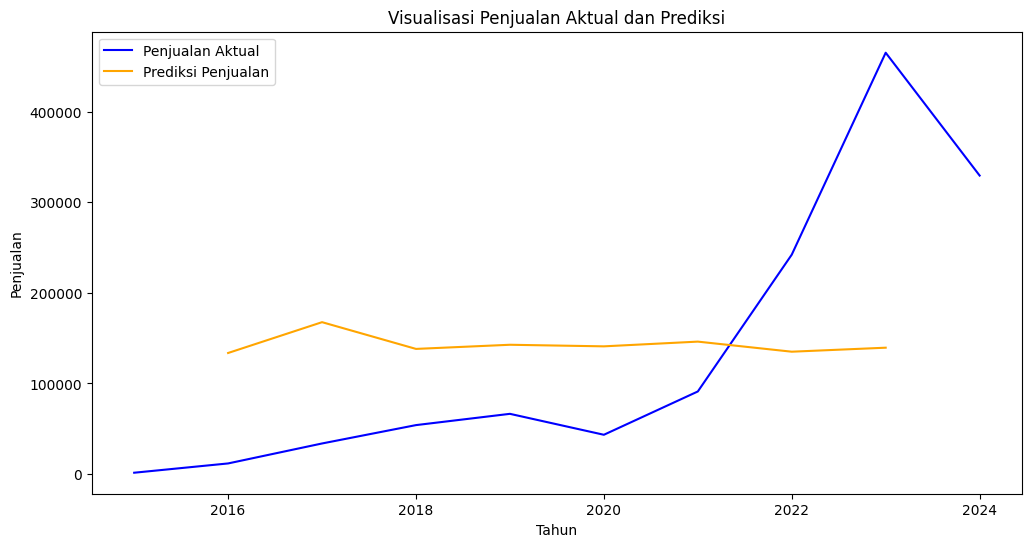

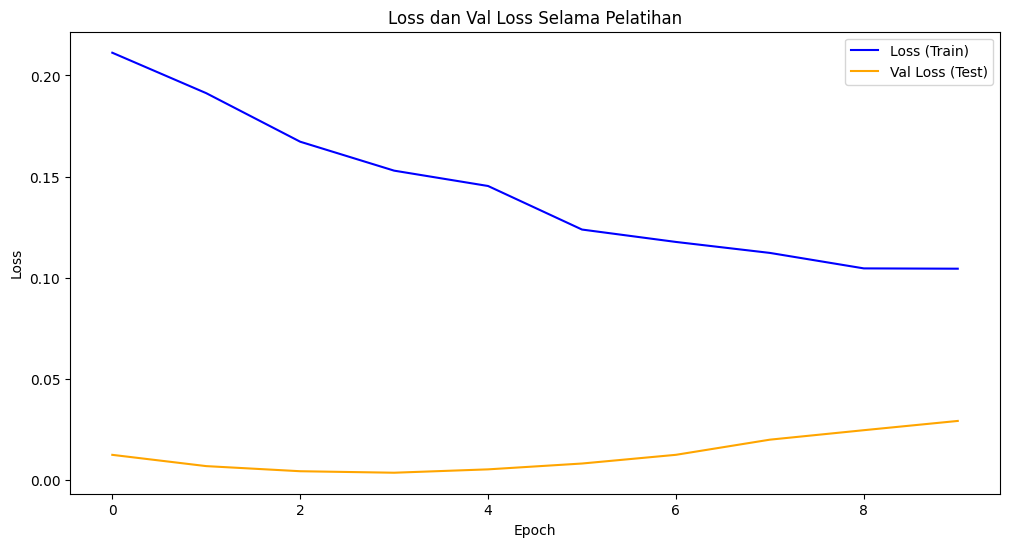

In [134]:
# Invers transformasi untuk mendapatkan nilai penjualan asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Menyusun array untuk visualisasi
predicted_sales = np.empty_like(data)
predicted_sales[:, :] = np.nan  # Inisialisasi dengan NaN

# Menempatkan prediksi train ke posisi yang benar
predicted_sales[time_step:len(train_predict) + time_step, :] = train_predict

# Menempatkan prediksi test ke posisi yang benar
start_index = len(train_predict) + time_step
predicted_sales[start_index:start_index + len(test_predict), :] = test_predict

# Menggabungkan hasil penjualan nyata dan prediksi untuk visualisasi
actual_sales = scaler.inverse_transform(data)  # Mengembalikan data ke skala asli

# Visualisasi penjualan tahunan dengan prediksi
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')
plt.plot(yearly_sales['Year'], predicted_sales, label='Prediksi Penjualan', color='orange')
plt.title('Visualisasi Penjualan Aktual dan Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Visualisasi loss dan val_loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss (Test)', color='orange')
plt.title('Loss dan Val Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


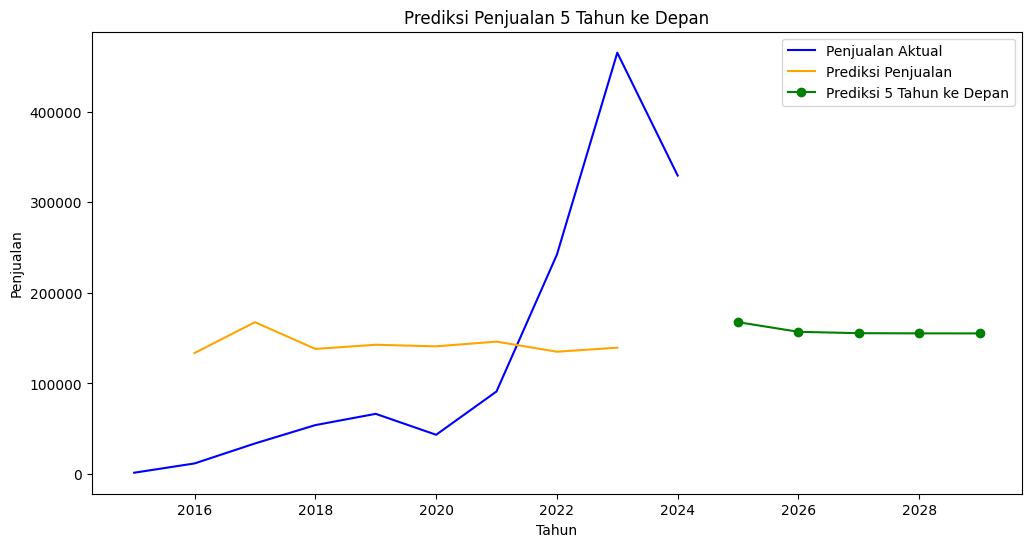

In [135]:
future_steps = 5
last_input = X[-1]
future_predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_input.reshape(1, time_step, 1))
    future_predictions.append(prediction[0, 0])
    last_input = np.append(last_input[1:], prediction)
    last_input = last_input.reshape(time_step, 1)

future_predictions = np.array(future_predictions)
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

last_year = yearly_sales['Year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + 1 + future_steps)

plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')
plt.plot(yearly_sales['Year'], predicted_sales, label='Prediksi Penjualan', color='orange')
plt.plot(future_years, future_predictions, label='Prediksi 5 Tahun ke Depan', color='green', marker='o')
plt.title('Prediksi Penjualan 5 Tahun ke Depan')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

#**TANPA SPLITTING DATA**

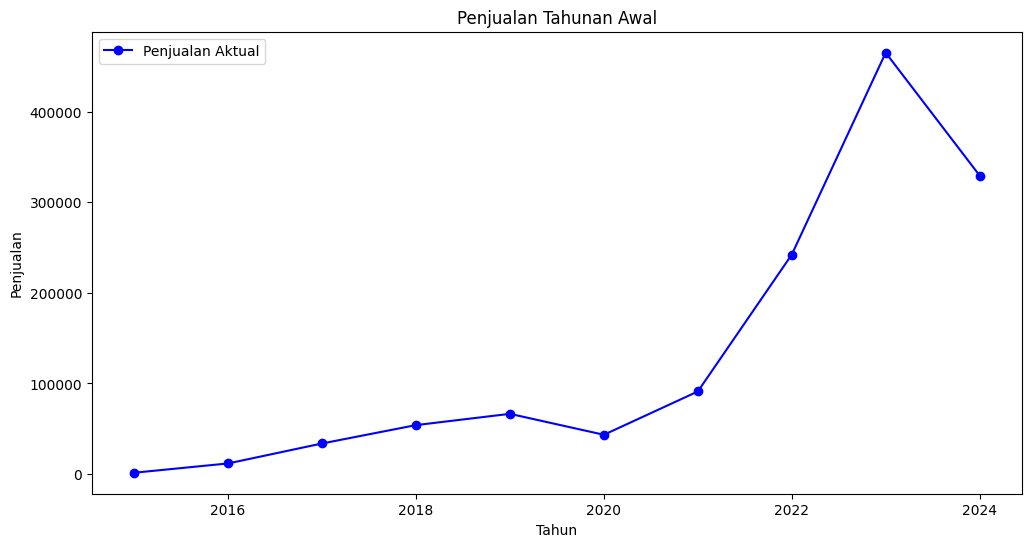

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2239
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0818 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0459     
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0311 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0670 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0351 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1375 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0719 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0907 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0564 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0771 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0559 
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1023 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0823 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1232 
Epoch 16/100
8/8 ━━━━━━━━━━━

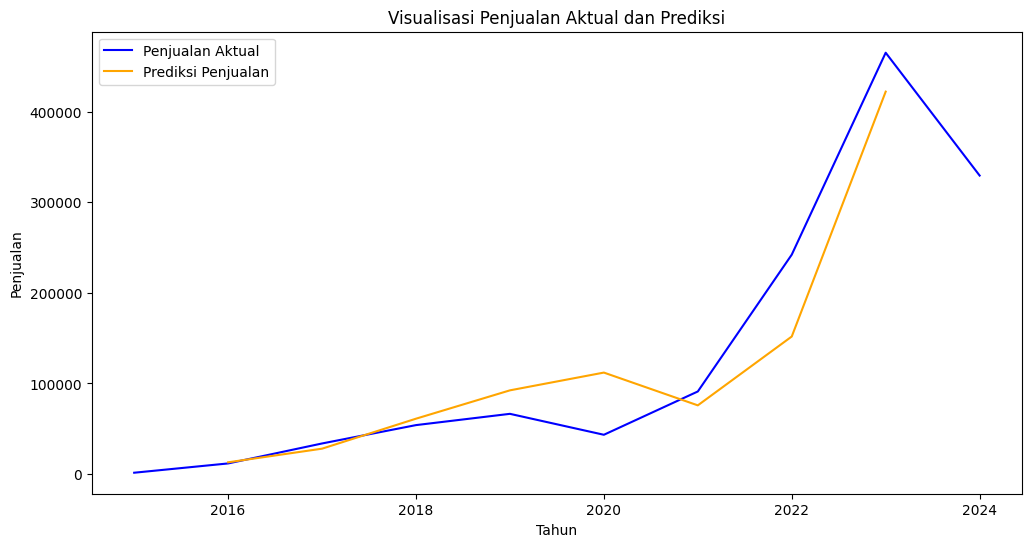

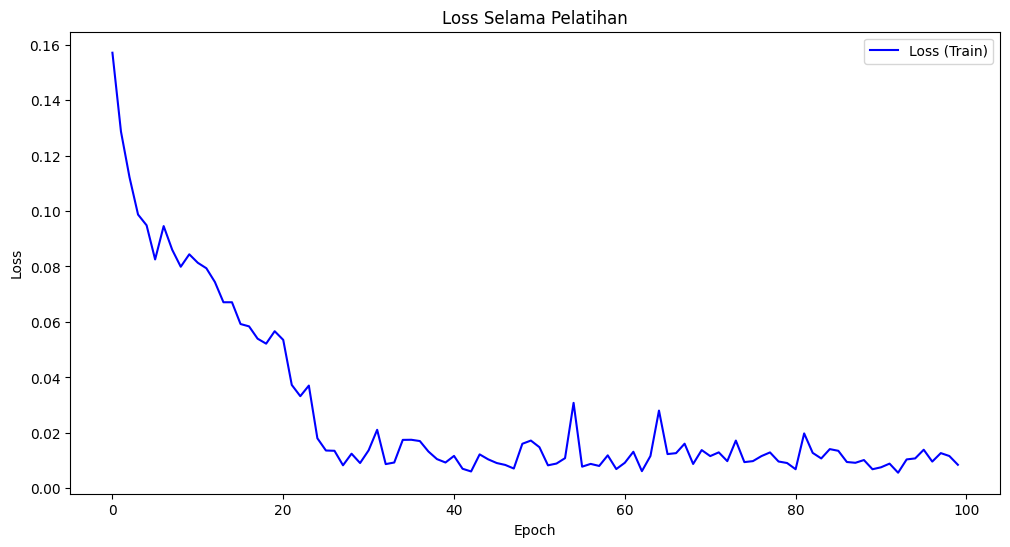

In [136]:

# Membaca dataset
ev_sales = pd.read_csv('https://raw.githubusercontent.com/dietadestina/PA_EVCast/main/ev_sales.csv')

# Mengelompokkan data berdasarkan tahun
yearly_sales = ev_sales.groupby('Year', as_index=False)['Value'].sum()

# Visualisasi penjualan tahunan awal
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], yearly_sales['Value'], label='Penjualan Aktual', color='blue', marker='o')
plt.title('Penjualan Tahunan Awal')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Normalisasi nilai penjualan
scaler = MinMaxScaler(feature_range=(0, 1))
yearly_sales['Value'] = scaler.fit_transform(yearly_sales['Value'].values.reshape(-1, 1))

# Mengubah data menjadi format yang sesuai untuk LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Mengubah dataframe menjadi numpy array
data = yearly_sales['Value'].values
data = data.reshape(-1, 1)

# Menetapkan jumlah langkah waktu
time_step = 1
X, y = create_dataset(data, time_step)

# Reshape input ke dalam bentuk [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Membangun model LSTM dengan lebih banyak dropout
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.3))  # Meningkatkan dropout
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))  # Meningkatkan dropout
model.add(Dense(25))
model.add(Dense(1))

# Mengompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model dengan seluruh data
history = model.fit(X, y, batch_size=1, epochs=100)  # Menggunakan seluruh data

# Melakukan prediksi pada seluruh data
predicted_sales = model.predict(X)

# Invers transformasi untuk mendapatkan nilai penjualan asli
predicted_sales = scaler.inverse_transform(predicted_sales)

# Menggabungkan hasil penjualan nyata dan prediksi untuk visualisasi
actual_sales = scaler.inverse_transform(data)

# Visualisasi penjualan tahunan dengan prediksi
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')
plt.plot(yearly_sales['Year'][time_step:len(predicted_sales) + time_step], predicted_sales, label='Prediksi Penjualan', color='orange')
plt.title('Visualisasi Penjualan Aktual dan Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Visualisasi loss selama pelatihan
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
plt.title('Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


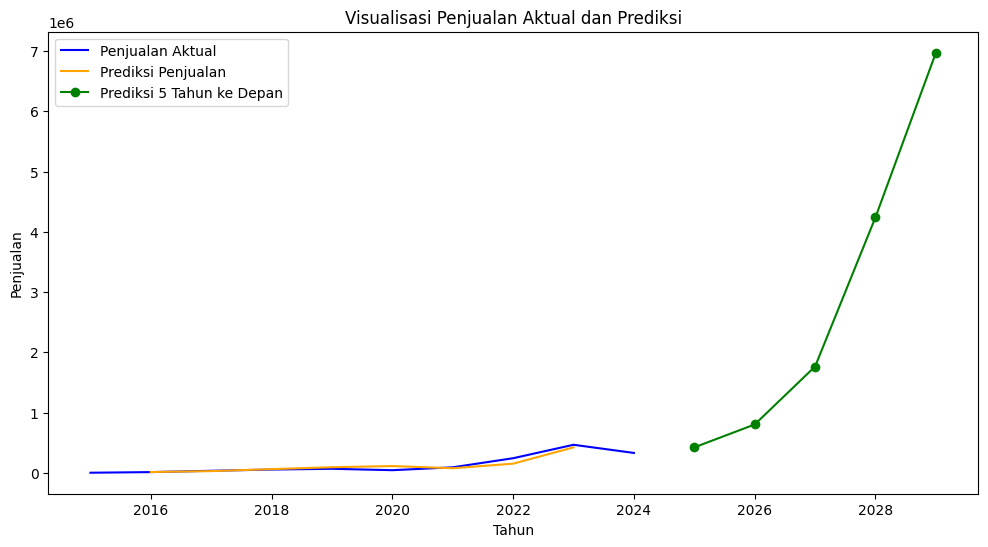

In [137]:
# Prediksi Penjualan untuk Tahun Mendatang (Misalnya 5 Tahun ke Depan)
future_steps = 5  # Prediksi untuk 5 tahun ke depan
last_input = X[-1]  # Mengambil data terakhir untuk memulai prediksi masa depan
future_predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_input.reshape(1, time_step, 1))
    future_predictions.append(prediction[0, 0])

    # Update last_input untuk prediksi selanjutnya
    last_input = np.append(last_input[1:], prediction)
    last_input = last_input.reshape(time_step, 1)

# Mengubah future_predictions menjadi numpy array sebelum inverse transform
future_predictions = np.array(future_predictions)

# Mengubah prediksi masa depan kembali ke skala asli
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Menyusun tahun prediksi
last_year = yearly_sales['Year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + 1 + future_steps)

# Visualisasi prediksi 5 tahun ke depan
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')

# Pastikan hanya menggunakan data prediksi yang sesuai dengan panjang data yang ada
plt.plot(yearly_sales['Year'][time_step:len(predicted_sales) + time_step], predicted_sales, label='Prediksi Penjualan', color='orange')

plt.plot(future_years, future_predictions, label='Prediksi 5 Tahun ke Depan', color='green', marker='o')
plt.title('Visualisasi Penjualan Aktual dan Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

#**TAHUN 2020**

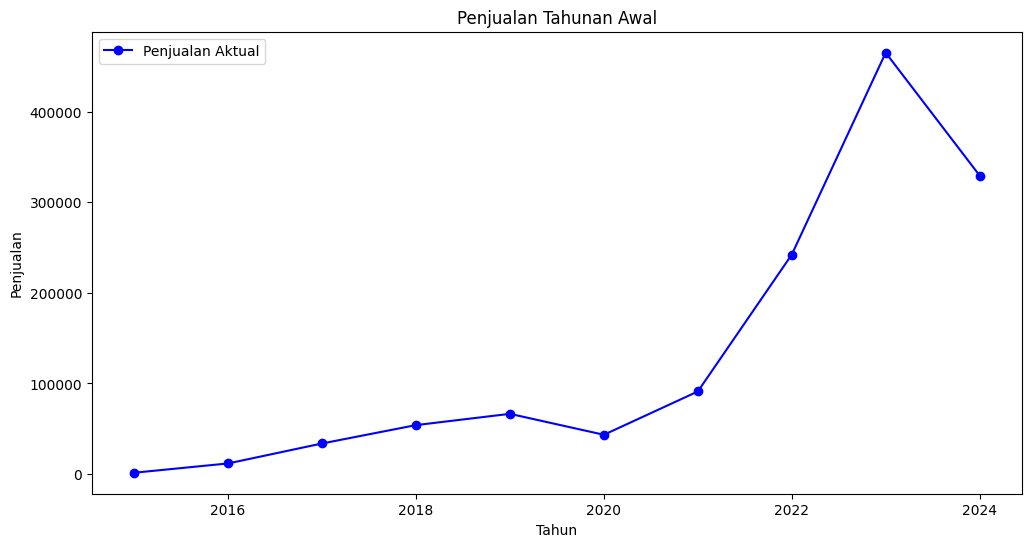

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0167 - val_loss: 0.5069
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.4362
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.3819
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_loss: 0.3825
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - val_loss: 0.3940
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.4072
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - val_loss: 0.3998
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.4038
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.4021
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 0.3924
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.3904
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - val_loss: 0.3736
Epoch 1

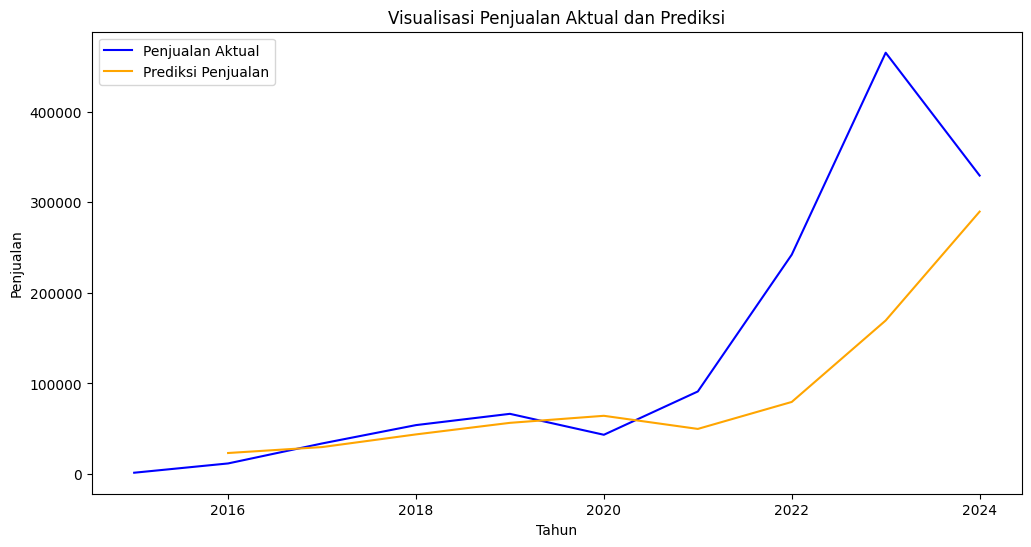

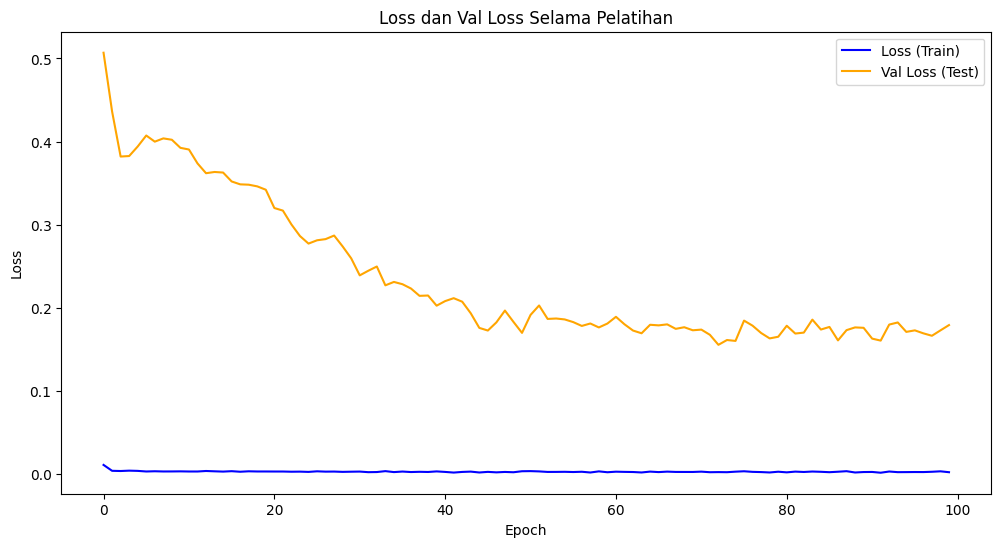

In [138]:
# Membaca dataset
ev_sales = pd.read_csv('https://raw.githubusercontent.com/dietadestina/PA_EVCast/main/ev_sales.csv')

# Mengelompokkan data berdasarkan tahun
yearly_sales = ev_sales.groupby('Year', as_index=False)['Value'].sum()

# Visualisasi penjualan tahunan awal
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], yearly_sales['Value'], label='Penjualan Aktual', color='blue', marker='o')
plt.title('Penjualan Tahunan Awal')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Normalisasi nilai penjualan
scaler = MinMaxScaler(feature_range=(0, 1))
yearly_sales['Value'] = scaler.fit_transform(yearly_sales['Value'].values.reshape(-1, 1))

# Mengubah data menjadi format yang sesuai untuk LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Mengubah dataframe menjadi numpy array
data = yearly_sales['Value'].values
data = data.reshape(-1, 1)

# Menetapkan jumlah langkah waktu
time_step = 1
X, y = create_dataset(data, time_step)

# Reshape input ke dalam bentuk [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Pembagian data berdasarkan tahun
# Mengambil data tahun
years = yearly_sales['Year'].values[:-time_step]  # Mengurangi satu untuk menyesuaikan dengan ukuran y

# Menentukan batas tahun untuk pembagian data
train_year = 2020
train_indices = years <= train_year
test_indices = years > train_year

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Membangun model LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.3))  # Meningkatkan dropout
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))  # Meningkatkan dropout
model.add(Dense(25))
model.add(Dense(1))

# Mengompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model dan menyimpan riwayat pelatihan
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=100)

# Melakukan prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Menghitung RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

# Invers transformasi untuk mendapatkan nilai penjualan asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Menyusun array untuk visualisasi
predicted_sales = np.empty_like(data)
predicted_sales[:, :] = np.nan  # Inisialisasi dengan NaN

# Menempatkan prediksi train ke posisi yang benar
predicted_sales[time_step:len(train_predict) + time_step, :] = train_predict

# Menempatkan prediksi test ke posisi yang benar
start_index = len(train_predict) + time_step
predicted_sales[start_index:start_index + len(test_predict), :] = test_predict

# Menggabungkan hasil penjualan nyata dan prediksi untuk visualisasi
actual_sales = scaler.inverse_transform(data)  # Mengembalikan data ke skala asli

# Visualisasi penjualan tahunan dengan prediksi
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')
plt.plot(yearly_sales['Year'], predicted_sales, label='Prediksi Penjualan', color='orange')
plt.title('Visualisasi Penjualan Aktual dan Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Visualisasi loss dan val_loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss (Test)', color='orange')
plt.title('Loss dan Val Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


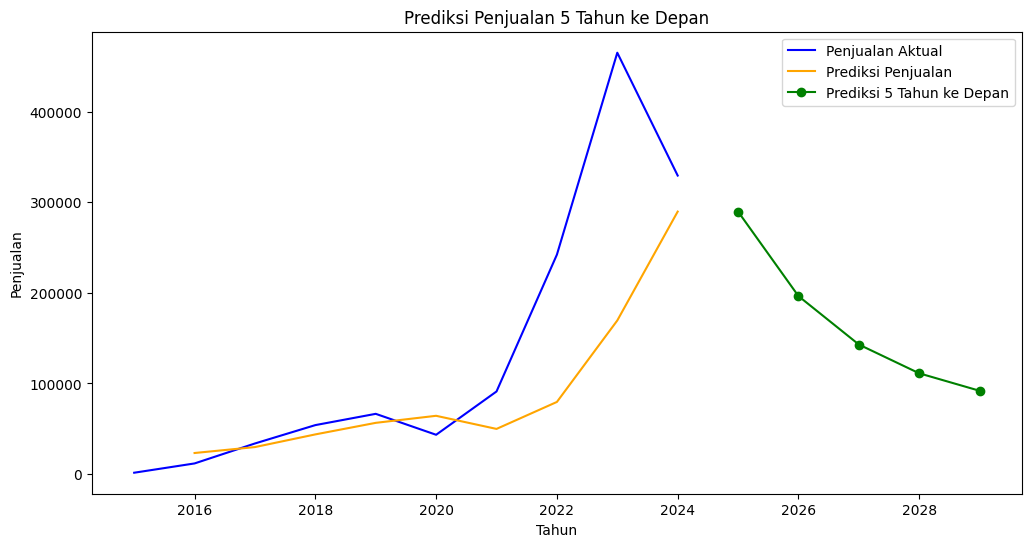

In [139]:
# Mengambil data terakhir dari X untuk prediksi tahun ke depan
future_steps = 5
last_input = X[-1]  # Mengambil data terakhir untuk memulai prediksi masa depan
future_predictions = []

for _ in range(future_steps):
    # Melakukan prediksi dan menambahkannya ke list
    prediction = model.predict(last_input.reshape(1, time_step, 1))
    future_predictions.append(prediction[0, 0])

    # Update last_input untuk prediksi selanjutnya
    last_input = np.append(last_input[1:], prediction)
    last_input = last_input.reshape(time_step, 1)

# Mengubah future_predictions menjadi numpy array sebelum inverse transform
future_predictions = np.array(future_predictions)

# Mengubah prediksi masa depan kembali ke skala asli
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Menyusun tahun prediksi
last_year = yearly_sales['Year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + 1 + future_steps)

# Visualisasi prediksi 5 tahun ke depan
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')
plt.plot(yearly_sales['Year'], predicted_sales, label='Prediksi Penjualan', color='orange')
plt.plot(future_years, future_predictions, label='Prediksi 5 Tahun ke Depan', color='green', marker='o')
plt.title('Prediksi Penjualan 5 Tahun ke Depan')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()